In [32]:
import pandas as pd
import geopandas as gpd
import os
import zipfile
import shutil
import folium

ZIPS_PATH = '../data/RJ-SETOR/'
TEMP_PATH = '../data/temp/'
CENSO_BASICO_PATH = '../data/CENSO/Basico_RJ.xls'
GEODATA_PATH = '../data/RJ-DATASET/DATASET.shp'
RIO_MUNIC_PATH = '../data/RJ-MUNIC/RJ-MUNIC.shp'
STD_CRS = '+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs'

## Reading data

In [2]:
for file in os.listdir(ZIPS_PATH):
    zipref = zipfile.ZipFile(os.path.join(ZIPS_PATH, file), 'r')
    zipref.extractall(TEMP_PATH)
    zipref.close()

In [3]:
codes = [x[:-4] for x in os.listdir(ZIPS_PATH)] #removing '.zip'
file_paths = [os.path.join(TEMP_PATH, "{}_setor.shp".format(x)) for x in codes] #full file paths
geodfs = [gpd.read_file(x) for x in file_paths] #reading all geo dataframes
setor = pd.concat(geodfs, ignore_index=True)
setor.shape, type(setor)

((10504, 14), geopandas.geodataframe.GeoDataFrame)

In [4]:
setor.head(1)

ID1       CD_GEOCODI    TIPO    CD_GEOCODB               NM_BAIRRO  \
0  408159  330455705270193  URBANO  330455705127  Ricardo de Albuquerque   

  CD_GEOCODD      NM_DISTRIT CD_GEOCODS NM_SUBDIST CD_GEOCODM      NM_MUNICIP  \
0  330455705  RIO DE JANEIRO  330455705   ANCHIETA    3304557  RIO DE JANEIRO   

                           NM_MESO        NM_MICRO  \
0  METROPOLITANA DO RIO DE JANEIRO  RIO DE JANEIRO   

                                            geometry  
0  POLYGON ((-43.40399 -22.84433, -43.40442 -22.8...

In [5]:
setor.to_crs(STD_CRS, inplace=True)

<AxesSubplot:>

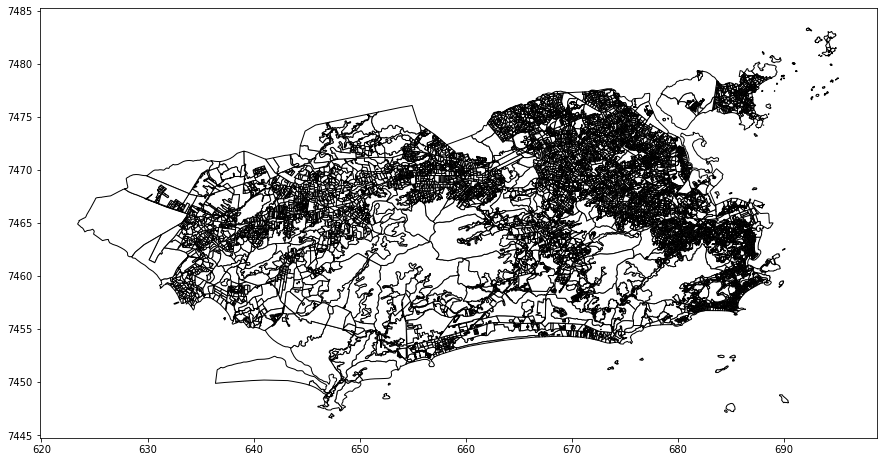

In [6]:
setor.plot(color='white', edgecolor='black', figsize=(15, 8))

<AxesSubplot:>

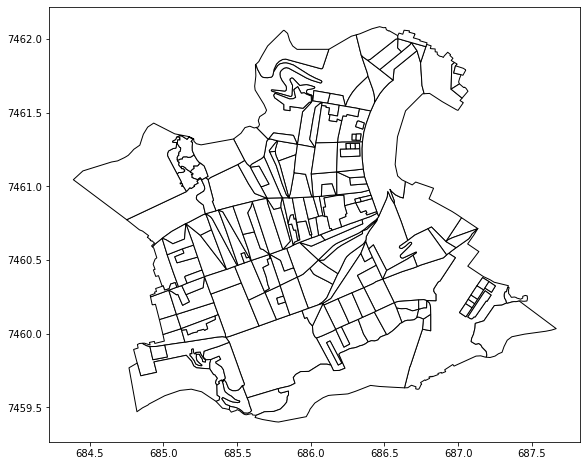

In [7]:
setor[setor['NM_BAIRRO'] == 'Botafogo'].plot(color='white', edgecolor='black', figsize=(15, 8))

## Adding Censo

In [8]:
censo = pd.read_excel(CENSO_BASICO_PATH)

In [9]:
censo.head(1)

Cod_setor  Cod_Grandes Regiões Nome_Grande_Regiao Cod_UF  \
0  330010005000001                    3     Região Sudeste     RJ   

      Nome_da_UF   Cod_meso    Nome_da_meso  Cod_micro        Nome_da_micro  \
0  Rio de Janeiro      3305  Sul Fluminense      33013  Baía da Ilha Grande   

   Cod_RM  ...  V003  V004    V005        V006     V007        V008     V009  \
0       0  ...  2.62  1.94  2356.8  5716056.06  2571.06  5684616.94  1565.37   

         V010     V011        V012  
0  4344465.56  2192.65  4711305.89  

[1 rows x 33 columns]

In [10]:
censo['Cod_setor'] = censo['Cod_setor'].astype(str)
censo['Cod_setor'].dtypes

dtype('O')

In [11]:
type(setor), type(censo)

(geopandas.geodataframe.GeoDataFrame, pandas.core.frame.DataFrame)

In [12]:
setor.shape, censo.shape

((10504, 14), (27769, 33))

In [13]:
setor = pd.merge(setor, censo, left_on='CD_GEOCODI', right_on='Cod_setor', how='left')
setor.shape

(10504, 47)

In [14]:
geodata = gpd.read_file(GEODATA_PATH)

<AxesSubplot:>

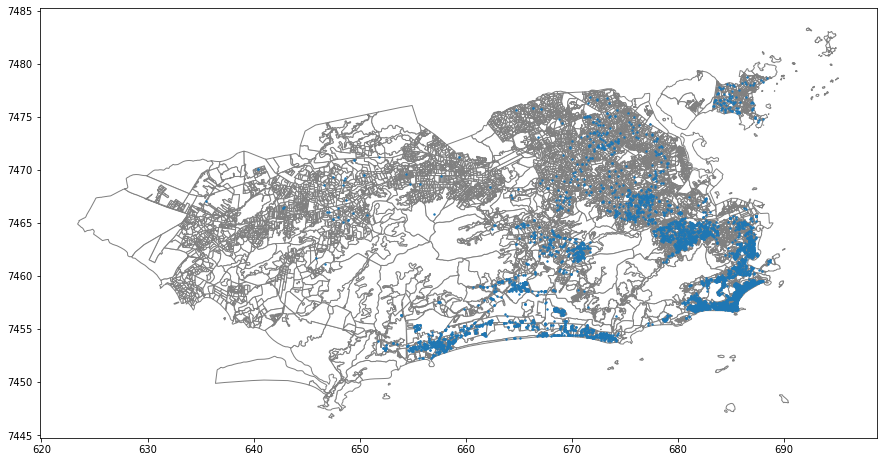

In [15]:
base = setor.plot(color='white', edgecolor='gray', figsize=(15, 8))
geodata.plot(ax=base, markersize=2)

## sjoin

In [16]:
geodata.shape

(4513, 14)

In [17]:
geodata = gpd.sjoin(geodata, setor, how='left', op='within')
geodata.shape #4516, 3 more than expected, because of points over borders

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/tmp/ipykernel_3778/3311698742.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["UTM_Zone_23_Southern_Hemisphere",GEOGCS["G ...
Right CRS: +proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0, ...

  geodata = gpd.sjoin(geodata, setor, how='left', op='within')


(4516, 61)

In [18]:
geodata = geodata[~geodata.index.duplicated(keep='first')] #removing
geodata.shape

(4513, 61)

## Agg

### Dissolve by some variable

In [20]:
#we need to use global projections, local ones, like UTM, doesn't work in this case
setor.to_crs(epsg=4326, inplace=True) 

NM_BAIRRO  \
0      Ricardo de Albuquerque   
1      Ricardo de Albuquerque   
2      Ricardo de Albuquerque   
3      Ricardo de Albuquerque   
4      Ricardo de Albuquerque   
...                       ...   
10499                 Estácio   
10500                 Estácio   
10501                 Estácio   
10502                 Estácio   
10503                 Estácio   

                                                geometry  
0      POLYGON ((-43.40399 -22.84433, -43.40442 -22.8...  
1      POLYGON ((-43.40680 -22.84522, -43.40625 -22.8...  
2      POLYGON ((-43.40625 -22.84487, -43.40680 -22.8...  
3      POLYGON ((-43.40634 -22.84279, -43.40707 -22.8...  
4      POLYGON ((-43.40707 -22.84338, -43.40827 -22.8...  
...                                                  ...  
10499  POLYGON ((-43.20844 -22.91940, -43.20845 -22.9...  
10500  POLYGON ((-43.20878 -22.91822, -43.20870 -22.9...  
10501  POLYGON ((-43.20844 -22.91694, -43.20764 -22.9...  
10502  POLYGON ((-43.20642 -22.91803, -43.20764 -22.9...  
10503  POLYGON ((-43.20550 -22.91572, -43.20602 -22.9...  

[10504 rows x 2 columns]

In [21]:
bairro = setor[['NM_BAIRRO', 'geometry']].dissolve(by='NM_BAIRRO')

<AxesSubplot:>

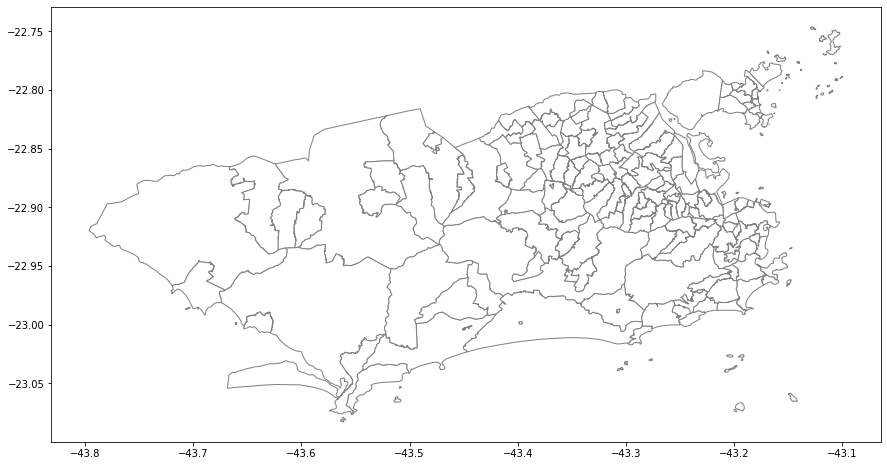

In [22]:
bairro.plot(color='white', edgecolor='gray', figsize=(15, 8))

### Agg func

In [24]:
#V002: population
bairro_pop = setor[['NM_BAIRRO', 'V002', 'geometry']].dissolve(by='NM_BAIRRO', aggfunc='sum')
bairro_pop.reset_index(inplace=True)
bairro_pop

NM_BAIRRO                                           geometry  \
0             Abolição  POLYGON ((-43.30071 -22.89112, -43.30094 -22.8...   
1                Acari  POLYGON ((-43.34222 -22.82782, -43.34253 -22.8...   
2    Alto da Boa Vista  POLYGON ((-43.29408 -22.97996, -43.29412 -22.9...   
3             Anchieta  POLYGON ((-43.41149 -22.83311, -43.41164 -22.8...   
4              Andaraí  POLYGON ((-43.25443 -22.93426, -43.25443 -22.9...   
..                 ...                                                ...   
155     Vila Valqueire  POLYGON ((-43.36708 -22.89711, -43.36718 -22.8...   
156      Vila da Penha  POLYGON ((-43.31466 -22.84846, -43.31551 -22.8...   
157       Vista Alegre  POLYGON ((-43.31923 -22.83183, -43.31931 -22.8...   
158              Zumbi  POLYGON ((-43.17556 -22.82367, -43.17560 -22.8...   
159         Água Santa  POLYGON ((-43.30348 -22.91473, -43.30400 -22.9...   

        V002  
0    11356.0  
1    26967.0  
2     9189.0  
3    55634.0  
4    39325.0  
..       ...  
155  32232.0  
156  25462.0  
157   8622.0  
158   2016.0  
159   7594.0  

[160 rows x 3 columns]

## Folium

In [30]:
rj = gpd.read_file(RIO_MUNIC_PATH)
rj.to_crs(epsg=4326, inplace=True)
x, y = rj.centroid.x.iloc[0], rj.centroid.y.iloc[0]
x, y

/tmp/ipykernel_3778/403147014.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x, y = rj.centroid.x.iloc[0], rj.centroid.y.iloc[0]
/tmp/ipykernel_3778/403147014.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x, y = rj.centroid.x.iloc[0], rj.centroid.y.iloc[0]


(-43.4502572955341, -22.92318738485863)

In [35]:
rj

ID CD_GEOCODM      NM_MUNICIP  \
0  1535    3304557  RIO DE JANEIRO   

                                            geometry  
0  MULTIPOLYGON (((-43.12376 -22.80712, -43.12380...

In [34]:
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap') #lon lat, using an open source map
base.choropleth(rj)
base

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [36]:
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap') #lon lat, using an open source map
geojson_rj = folium.GeoJson(rj)
geojson_rj.add_child(folium.Popup(rj['NM_MUNICIP'].iloc[0])) #configuring geojson to popup city name
geojson_rj.add_to(base) #adding new layer
base

In [40]:
bairro_pop.to_crs(epsg=4326, inplace=True)
bairro_pop

NM_BAIRRO                                           geometry  \
0             Abolição  POLYGON ((-43.30071 -22.89112, -43.30094 -22.8...   
1                Acari  POLYGON ((-43.34222 -22.82782, -43.34253 -22.8...   
2    Alto da Boa Vista  POLYGON ((-43.29408 -22.97996, -43.29412 -22.9...   
3             Anchieta  POLYGON ((-43.41149 -22.83311, -43.41164 -22.8...   
4              Andaraí  POLYGON ((-43.25443 -22.93426, -43.25443 -22.9...   
..                 ...                                                ...   
155     Vila Valqueire  POLYGON ((-43.36708 -22.89711, -43.36718 -22.8...   
156      Vila da Penha  POLYGON ((-43.31466 -22.84846, -43.31551 -22.8...   
157       Vista Alegre  POLYGON ((-43.31923 -22.83183, -43.31931 -22.8...   
158              Zumbi  POLYGON ((-43.17556 -22.82367, -43.17560 -22.8...   
159         Água Santa  POLYGON ((-43.30348 -22.91473, -43.30400 -22.9...   

        V002  
0    11356.0  
1    26967.0  
2     9189.0  
3    55634.0  
4    39325.0  
..       ...  
155  32232.0  
156  25462.0  
157   8622.0  
158   2016.0  
159   7594.0  

[160 rows x 3 columns]

In [42]:
bairro_pop[0:1] #trick

NM_BAIRRO                                           geometry     V002
0  Abolição  POLYGON ((-43.30071 -22.89112, -43.30094 -22.8...  11356.0

In [48]:
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap') 

for i in range(len(bairro_pop)):
    #creating geojson object (to use as folium layer) for each "bairro"
    gj = folium.GeoJson(bairro_pop[i:i+1], name=bairro_pop['NM_BAIRRO'][i])
    
    #adding a popup to the geojson object
    popup_label = '{} {}'.format(bairro_pop['NM_BAIRRO'][i], int(bairro_pop['V002'][i]))
    folium.Popup(popup_label).add_to(gj)
    
    #adding final "bairro" geojson to base
    gj.add_to(base)

folium.LayerControl().add_to(base)

base.save('rj_bairros_pop.html')
base

## Houses locations and prices

In [52]:
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap')
base.choropleth(
    rj,
    name="Rio de Janeiro",
    line_color='black',
    line_weight=2,
    fill_opacity=0
)

sample = geodata.sample(100)

for item in sample.itertuples():
    base.add_child(
        folium.Marker(
            location=[item.Latitude, item.Longitude],
            popup = "<h4>Tipo: {}</h4> <h5>Bairro: {}</h5> <p>Valor: R$ {},00</p>".format(
                item.Tipo, item.Bairro, item.Valor
            ),
            #https://fontawesome.com/v4.7/icons/
            icon=folium.Icon(color='red', prefix='fa', icon='fas fa-home')
        )
    )

folium.LayerControl().add_to(base)

base.save('casas_e_precos.html')

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


### Using marker clusters

In [53]:
from folium.plugins import MarkerCluster

In [55]:
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap')
base.choropleth(
    rj,
    name="Rio de Janeiro",
    line_color='black',
    line_weight=2,
    fill_opacity=0
)

#sample = geodata.sample(100)
cluster = MarkerCluster()

for item in geodata.itertuples():
    #base.add_child(
    cluster.add_child(
        folium.Marker(
            location=[item.Latitude, item.Longitude],
            popup = "<h4>Tipo: {}</h4> <h5>Bairro: {}</h5> <p>Valor: R$ {},00</p>".format(
                item.Tipo, item.Bairro, item.Valor
            ),
            #https://fontawesome.com/v4.7/icons/
            icon=folium.Icon(color='red', prefix='fa', icon='fas fa-home')
        )
    )

base.add_child(cluster)
    
folium.LayerControl().add_to(base)

base.save('casas_e_precos_clusterizado.html')

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## Heatmaps

In [56]:
from folium.plugins import HeatMap

In [71]:
setor.to_crs(epsg=4326, inplace=True)
rj.to_crs(epsg=4326, inplace=True)
setor.fillna(0, inplace=True)
rj.fillna(0, inplace=True)

In [72]:
x, y #RJ centroids

(-43.4502572955341, -22.92318738485863)

In [73]:
data = list()
for i in range(len(setor)):
    data.append([
        setor['geometry'][i].centroid.y,
        setor['geometry'][i].centroid.x,
        setor['V002'][i] / setor['V002'].max()
    ])
data

[[-22.843192155774354, -43.40349659177087, 0.11025399811853245],
 [-22.844398595714562, -43.40050936760041, 0.10630291627469426],
 [-22.84422462423656, -43.406952280552225, 0.10009407337723425],
 [-22.84230573719254, -43.40576729473774, 0.1279397930385701],
 [-22.842750489306678, -43.40881464297014, 0.1572906867356538],
 [-22.840883894030064, -43.4095562044065, 0.17704609595484477],
 [-22.843995078346428, -43.40505093659312, 0.1380997177798683],
 [-22.838037880637845, -43.40456763539683, 0.11589840075258702],
 [-22.839436667127153, -43.408107549178574, 0.14656632173095013],
 [-22.841109068927185, -43.40680074694962, 0.1986829727187206],
 [-22.846377286603776, -43.364550452196966, 0.1599247412982126],
 [-22.848531955526507, -43.37061584980728, 0.031796801505174034],
 [-22.846509355583112, -43.367575369615444, 0.14355597365945438],
 [-22.84912928965638, -43.37294578212708, 0.15051740357478832],
 [-22.84939510368349, -43.37744228755721, 0.09952963311382879],
 [-22.84787460001183, -43.3787

In [74]:
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap')
HeatMap(data, name='Population').add_to(base)
folium.LayerControl().add_to(base)
base.save('heatmap.html')
base